In [ ]:
!pip install arize-phoenix openinference-instrumentation-dspy opentelemetry-exporter-otlp

In [ ]:
!pip install "dspy-ai[mongodb]" cohere "dspy-ai[faiss-cpu]"

In [21]:
!pip install ca-vntl-helper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import phoenix as px

px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [3]:
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
import dspy
import dsp
import cohere
import json
import functools
from dotenv import load_dotenv
import os
import requests
from datetime import datetime
import backtrader as bt
load_dotenv('.env')

endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

In [4]:
class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='$\u21E7$', markersize=12.0),
        sell=dict(marker='$\u21E9$', markersize=12.0)
    )


def init_cerebro_object(strategy, list_of_data, stake = 100, cash=20000):
    cerebro = bt.Cerebro(cheat_on_open=True)
    cerebro.addstrategy(strategy)
    
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')

    
    for data in list_of_data:
        cerebro.adddata(data)
    cerebro.broker.set_cash(cash)
    
    # better net liquidation value view
    cerebro.addobserver(bt.observers.Value)
    bt.observers.BuySell = MyBuySell
    
    return cerebro

def run_cerebro(strategy, list_data, stake=100, cash=20000):
    cerebro = init_cerebro_object(strategy, list_data, stake, cash)
    thestrats = cerebro.run(stdstats=True)
    return cerebro, thestrats


def get_code_from_text(text):
    """Extracts the Python code segment from the provided text."""
    print("Text",text)
    code_segment = text
    if "```" in text:
        code_segment = code_segment.split("```")[1]
    if "```python" in text:
        code_segment = code_segment[6:]
    return code_segment.strip()

def load_base_strategy():
    """Loads the base strategy code from the base_strategy.py file."""
    with open("base_strategy.py", "r") as f:
        base_strats = "\n".join(f.readlines())
    return base_strats

def extract_error_message(error):
    error_lines = str(error).split('\n')
    for line in error_lines:
        if 'Error' in line or 'Exception' in line:
            return line.strip()
    return error_lines[-1].strip()

def load_file(file: str):
    """Loads content of file."""
    with open(file, "r") as f:
        contents = "\n".join(f.readlines())
    return contents

text = load_file("cleaned_text.txt")

texts = text.split("\n\n\n\n")

In [5]:
base_strats = load_base_strategy()

prompt = "Please create a strategy that buys when the price moves a certain percentage above the ATR value and sells when the price moves the same percentage below the ATR value"

instruction = f"""
    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestStrategy
    ----------------------------
    "{base_strats}"
    """

In [9]:
# Get example
import pandas as pd
import re
from prompt_retry import prompt_error

# Define a simple signature for basic question answering
# Define a signature for generating a specific finance strategy from Python code
class FinanceStrategyGenerator(dspy.Signature):
    """Generate Python code for a specified finance strategy."""
    context = dspy.InputField(desc="Code structure and instruction for the finance strategy.")
    question = dspy.InputField(desc="Query of the finance strategy.")
    # generated_code = dspy.OutputField(desc="Generated Python code format for the strategy inside ```python``` block.")
    # answer = dspy.OutputField(desc="Generated Python code for the strategy, formatted inside ```python``` block. If Backtrader is indicated, the code will inherit from Backtrader's Indicator class; otherwise, it will generate an LLM's knowledge indicator.")
    answer = dspy.OutputField(desc="Generated Python code for the strategy, formatted inside only ```python``` block.")


    
class CSVDataset:
    def __init__(self, file_path, instruction=None) -> None:
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Change name of the columns
        df.columns = ['question', 'answer']
        
        instruction = instruction if instruction else "You are a data scientist that intent to make a workable strategy from human requirement"
        
        
        df['context'] = [instruction] * len(df)
        df = df.drop(columns=['answer'])
        
        df = df.sample(frac=1).reset_index(drop=True)
        
        
        self.train = self._change_input(df.iloc[:70].to_dict(orient='records'))
        self.dev = self._change_input(df.iloc[70:].to_dict(orient='records'))
        
    
    def _change_input(self, input_data):
        
        ds = []
        for d in input_data:
            ds.append(dict(
                context=d['context'],
                question=d['question'],
                # answer=d['answer']
            ))
        d = [dspy.Example(**x).with_inputs("context", "question") for x in ds]
        return d
    

file_path = "/Data/complex_trading_strategies.csv"
dataset = CSVDataset(file_path=file_path, instruction=instruction)

In [20]:
def check_valid_code(strategy, list_data):
    try:
        cerebro, thestrats = run_cerebro(strategy, list_data)
        return True, ""
    except Exception as e:
        error_message = extract_error_message(e)
        return False, error_message


class GenerateCodeWithAssert(dspy.Module):
  def __init__(self, list_ohcl_data):
    super().__init__()
    self.generate_result = dspy.ChainOfThought(FinanceStrategyGenerator)
    self.ohcl_data = list_ohcl_data
    self.num_retry = 0
    self.flag = 0
    self.retrieve = dspy.Retrieve(k=3)
    self.content_retrieve = None
  
  def forward(self, context, question):
    ex = self.generate_result(context=context, question=question)
    
    if not self.content_retrieve:
      self.content_retrieve = self.retrieve(question).passages
      
    if self.flag == 0:
        self.flag = 1
    else:
        self.num_retry += 1
      
    exec(get_code_from_text(ex.answer), globals())
    check, error = check_valid_code(BackTestStrategy, self.ohcl_data)
    # dspy.Assert(check, f"Fix error {error}")

    p_error = prompt_error(error, content=self.content_retrieve)
    dspy.Suggest(check, f"{p_error}")
    # dspy.Suggest(check, f"The code must not obtain the error {error}")
    
    ex['num_retry'] = self.num_retry
    self.num_retry, self.flag = 0, 0
    self.content_retrieve = None

    return ex


In [25]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from ver_3.data_loader import load_stock_data
from ver_3.base_strategy import BaseStrategy
from dspy.predict import Retry
from dspy.retrieve.faiss_rm import FaissRM

# Anyscale
lm = dspy.Anyscale(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    max_tokens=512, 
    use_chat_api=True
)

# Groq
# lm = dspy.GROQ(
#     model="llama3-70b-8192",
#     api_key="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",
#     max_tokens=512,
# )

# Together
# lm = dspy.Together(model="deepseek-ai/deepseek-coder-33b-instruct", max_tokens=512, use_chat_api=True)

# Setting retriever
frm = FaissRM(texts)

dspy.settings.configure(lm=lm, trace=[], max_assertions=10, rm=frm)

data = [bt.feeds.PandasData(
                dataname=load_stock_data(ticker='AAPL', period="1y"), datetime="Date", 
                timeframe=bt.TimeFrame.Minutes)]

generate_with_assert = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=5))

example = generate_with_assert(dataset.train[0].context, dataset.train[0].question)

print(f"Question: {prompt}")
print(f"Final Predicted Answer (after CoT process): {example.answer}")
print(f"Number of Retries: {example.num_retry}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
WARNING clustering 126 points to 100 centroids: please provide at least 3900 training points
[*********************100%%**********************]  1 of 1 completed
ERROR [dspy.primitives.assertions] 2024-06-21T07:41:09.849091Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0

In [17]:
lm.inspect_history(n=3)




Generate Python code for a specified finance strategy.

---

Follow the following format.

Context: Code structure and instruction for the finance strategy.

Question: Query of the finance strategy.

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Generated Python code for the strategy, formatted inside only ```python``` block.

---

Context:

    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestStrategy
    ----------------------------
    "import backtrader as bt





class BaseStrategy(bt.Strategy):

    def __init__(self, debug=T

'\n\n\nGenerate Python code for a specified finance strategy.\n\n---\n\nFollow the following format.\n\nContext: Code structure and instruction for the finance strategy.\n\nQuestion: Query of the finance strategy.\n\nReasoning: Let\'s think step by step in order to ${produce the answer}. We ...\n\nAnswer: Generated Python code for the strategy, formatted inside only ```python``` block.\n\n---\n\nContext:\n\n    You are a python developer that intent to make a workable strategy from human requirement.\n    Your task is to create a new BackTestStrategy that follow below msg\n    Note: Only return class strategy and change `execute` function only, nothing else.\n       \n    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.\n    Please name your class strategy as BackTestStrategy\n    ----------------------------\n    "import backtrader as bt\n\n\n\n\n\nclass BaseStrategy(bt.Strate

2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Final Portfolio Value: 1015.30
Total point return:  15.29998779296875


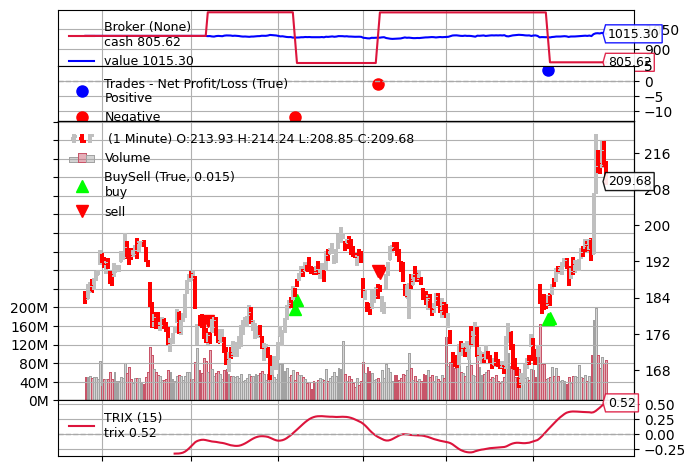

In [12]:
import matplotlib
%matplotlib inline
cerebro, thestrats = run_cerebro(strategy=BackTestStrategy, list_data=data, stake=100, cash=1000)
    #thestrat = thestrats[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print("Total point return: ", (cerebro.broker.getvalue() - cerebro.broker.startingcash))


sharpe_ratio = thestrats[0].analyzers.SharpeRatio.get_analysis()['sharperatio']
# Plot the results
figs = cerebro.plot(
    iplot=False, 
    style="pincandle", 
    # width=60 * 10, height=40 * 10,
    figsize=(100, 80),
    sharpe_ratio=sharpe_ratio
)


In [21]:

thestrats[0].analyzers.SharpeRatio.get_analysis()['sharperatio']

-0.6339025587327569

# Finetuning prompt 

In [22]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy.evaluate.metrics import answer_exact_match
from ca_vntl_helper import error_tracking_decorator
from dspy.evaluate import Evaluate

def validate_answer(example, prediction, trace=None):
    print("Example", prediction)
    return prediction.num_retry <= 5 and prediction.answer is not None


evaluate = Evaluate(
    devset = dataset.dev[:3],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)


In [21]:
evaluate(generate_with_assert)

  0%|          | 0/3 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):  33%|███▎      | 1/3 [00:11<00:22, 11.11s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 189.49, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

Average Metric: 2 / 2  (100.0):  67%|██████▋   | 2/3 [00:21<00:10, 10.82s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

ERROR [dspy.primitives.assertions] 2024-06-20T18:05:40.607506Z [error    ] SuggestionFailed: The code must not obtain the error  module 'backtrader.indicators' has no attribute 'MAE' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae = bt.ind.MAE(self.data.close, period=15, devfactor=2)

    def execute(self):
        if self.data.close > self.mae.upper:
            return 1
        elif self.data.close < self.mae.lower:
            return -1
        return 0
```


Average Metric: 3 / 3  (100.0): 100%|██████████| 3/3 [00:36<00:00, 12.31s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=15) + 2 * bt.ind.StdDev(self.data.close, period=15)
        self.mae_lower = bt.ind.SMA(self.data.close, period=15) - 2 * bt.ind.StdDev(self.data.close, period=15)

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-30T00:05:00, CLOSE SELL, Price: 184.94, Cost: -182.13, Comm 0.00f
2023-08-31T00:05:00, BUY EXECUTED, Price: 187.84, Cost: 187.84, Comm 0.00f
2023-09-28T00:05:00, CLOSE BUY, Price: 169.34, Cost: 187.84, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-12-06T00:

,context,question,rationale,answer,num_retry,validate_answer
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the TRIX (a triple-smoothed EMA) crosses above the signal line and sells when it crosses below the signal line.,"produce the answer. We need to create a new strategy class that inherits from the BaseStrategy class. We will use the TRIX indicator, which is...","```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) self.signal = bt.ind.SMA(self.trix, period=9) def execute(self): if self.trix > self.signal: return 1...",0,✔️ [True]
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Aroon Up crosses above the Aroon Down and sells when the Aroon Down crosses above the Aroon Up.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down: return 1...","```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0]...",0,✔️ [True]
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Moving Average Envelopes indicator's close crosses above its upper band and sells when it crosses below its lower...,nan,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.mae_upper = bt.ind.SMA(self.data.close, period=15) + 2 * bt.ind.StdDev(self.data.close, period=15) self.mae_lower = bt.ind.SMA(self.data.close, period=15) - 2 *...",1,✔️ [True]


100.0

In [19]:

teleprompter = BootstrapFewShotWithRandomSearch(metric = validate_answer, max_bootstrapped_demos=2, num_candidate_programs=6)

# generated_code_student_teacher = teleprompter.compile(
#                 student=assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler), 
#                 teacher = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler), 
#                 trainset=dataset.train[:10], 
#                 valset=dataset.dev[10:15]
# )


generated_code_student_teacher = teleprompter.compile(
                student=assert_transform_module(
                    GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=10)), 
                teacher = assert_transform_module(
                    GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=5)), 
                trainset=dataset.train[:10], 
                valset=dataset.dev[10:15]

)

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR [dspy.primitives.assertions] 2024-06-21T04:48:04.095592Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:48:08.327574Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:48:12.863380Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:25<01:42, 25.64s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:00, 

ERROR [dspy.primitives.assertions] 2024-06-21T04:48:28.223400Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:41<00:59, 19.74s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T04:48:43.949072Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:48:48.782720Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:48:52.673922Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:48:57.379629Z [error    ] SuggestionFailed: The code must not obtain the error  __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:02.725396Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:07.740094Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed[0] > 0 and self.pvt.smoothed[0] > self.pvt.smoothed[-1]:
            return 1
        elif self.pvt.smoothed[0] < 0 and self.pvt.smoothed[0] < self.pvt.smoothed[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:14.465403Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28, upperband=70.0, lowerband=30.0)

    def execute(self):
        if self.pvt.uo[0] > self.pvt.uo[-1] and self.pvt.uo[0] > 50:
            return 1
        elif self.pvt.uo[0] < self.pvt.uo[-1] and self.pvt.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:19.452763Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:25.391496Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:31.828320Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:49:38.585731Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)\n\n    def execute(self):\n        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:\n            return 1\n        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:\n            return -1\n        return 0\n`

Average Metric: 3 / 4  (75.0):  80%|████████  | 4/5 [01:55<00:28, 28.24s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [02:05<00:00, 25.07s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T04:50:09.706680Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:50:14.276659Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:50:19.238454Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:50:23.694903Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:50:28.473501Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:35<02:22, 35.56s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:00, 

ERROR [dspy.primitives.assertions] 2024-06-21T04:50:43.479812Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:50<01:11, 23.70s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T04:50:58.775104Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:03.684354Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:07.881832Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:12.715758Z [error    ] SuggestionFailed: The code must not obtain the error  __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:18.030007Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:23.444180Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed[0] > 0 and self.pvt.smoothed[0] > self.pvt.smoothed[-1]:
            return 1
        elif self.pvt.smoothed[0] < 0 and self.pvt.smoothed[0] < self.pvt.smoothed[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:28.846800Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28, upperband=70.0, lowerband=30.0)

    def execute(self):
        if self.pvt.uo[0] > self.pvt.uo[-1] and self.pvt.uo[0] > 50:
            return 1
        elif self.pvt.uo[0] < self.pvt.uo[-1] and self.pvt.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:33.383712Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:38.811403Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:44.573994Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:51:50.475487Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)\n\n    def execute(self):\n        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:\n            return 1\n        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:\n            return -1\n        return 0\n`

Average Metric: 3 / 4  (75.0):  80%|████████  | 4/5 [02:02<00:28, 28.77s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [02:13<00:00, 26.68s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T04:52:20.985409Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


 10%|█         | 1/10 [00:14<02:13, 14.79s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T04:52:35.893986Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


 20%|██        | 2/10 [00:29<01:58, 14.85s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T04:52:49.533171Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:52:54.727439Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:52:59.966836Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:05.670593Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:11.104027Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:16.523054Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:21.861926Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:26.986838Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:32.639870Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:38.094305Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:53:43.472341Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)\n\n    def execute(self):\n        if len(self.uo) > 1:\n            if self.uo[0] > 50 and self.uo[-1] <= 50:\n                return 1\n            elif self.uo[0] < 50 and self.uo[-1] >= 50:\n                return -1\n        return 0\n```',
    num_retry=10
)


Average Metric: 1 / 2  (50.0):  40%|████      | 2/5 [01:11<01:33, 31.24s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T04:54:00.225446Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:05.377130Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:10.473574Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PV_Trend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PV_Trend(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:16.251966Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:22.161010Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:27.673949Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:33.040370Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:38.913769Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:44.254561Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:49.197790Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:54:54.389199Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=3)\n\n    def execute(self):\n        if len(self.pvt) > 1:\n            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:\n                return 1\n            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:\n                return -1\n        return 0\n```',
    

ERROR [dspy.primitives.assertions] 2024-06-21T04:55:11.068154Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if len(self.aroon_up) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]:
                return 1
            elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]:
                return -1
        return 0
```


Average Metric: 2 / 4  (50.0):  80%|████████  | 4/5 [02:36<00:36, 36.33s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if len(self.aroon_up) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]:
                return 1
            elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]:
                return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, 

ERROR [dspy.evaluate.evaluate] 2024-06-21T04:55:33.111967Z [error    ] Error for example in dev set: 		 invalid syntax (<string>, line 1) [dspy.evaluate.evaluate] filename=evaluate.py lineno=146
Average Metric: 2.0 / 5  (40.0): 100%|██████████| 5/5 [02:52<00:00, 34.52s/it]


Text ```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data.close, period=14) self.aroon_down = bt.ind.AroonDown(self.data.close, period=14) def execute(self): if len(self.aroon_up) > 1: if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]: return 1 elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]: return -1 return 0 ```


 10%|█         | 1/10 [00:10<01:30, 10.07s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

ERROR [dspy.primitives.assertions] 2024-06-21T04:55:54.912457Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - dista

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:55:59.329121Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - dista

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:04.123409Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - dista

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:08.519383Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - distance to lowes

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:13.153238Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - dista

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:17.485250Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: AroonUpDown

Alias:AroonIndicator

Formula:

    up = 100 * (period - distance to highest high) / period

    down = 100 * (period - distance to lowest low) / period

Returns: aroonup, aroondown

Params: period (14), upperband (70), lowerband (30)



Name: AroonUp

Alias: AroonUp

Formula: up = 100 * (period - distance to highest high) / period

Returns: aroonup

Params: period (14), upperband (70), lowerband (30)



Name: AroonDown

Alias: AroonDown

Formula: down = 100 * (period - dista

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)\n\n    def execute(self):\n        if self.cmf > 0 and self.cmf[-1] < 0:\n            return 1\n        elif self.cmf < 0 and self.cmf[-1] > 0:\n            return -1\n        return 0\n```',
    num_retry=5
)


  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T04:56:28.611514Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo[-1] < 50 and self.uo[0] > 50:
            return 1
        elif self.uo[-1] > 50 and self.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:33.865102Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo[-1] < 50 and self.uo[0] > 50:
            return 1
        elif self.uo[-1] > 50 and self.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:38.338493Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo[-1] < 50 and self.uo[0] > 50:
            return 1
        elif self.uo[-1] > 50 and self.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:56:43.772404Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)
    def execute(self):
        if self.uo[-1] < 50 and self.uo[0] > 50:
            return 1
        elif self.uo[-1] > 50 and self.uo[0] < 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:31<02:04, 31.07s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo[-1] < 50 and self.uo[0] > 50:
            return 1
        elif self.uo[-1] > 50 and self.uo[0] < 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:

Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:40<00:55, 18.50s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix[0] > self.trix[-1]:
            return 1
        elif self.trix < 0 and self.trix[0] < self.trix[-1]:
            return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='```python\nclass BackTestStrategy(BaseSt

ERROR [dspy.primitives.assertions] 2024-06-21T04:57:07.878773Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:13.490346Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:18.722647Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:23.980444Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:28.553413Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:33.770682Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:38.356361Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:43.119161Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:47.913480Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:53.079007Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:57:57.897342Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.OnBalanceVolume(self.data)\n\n    def execute(self):\n        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:\n            return 1\n        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:\n            return -1\n        return 0\n```',
    num_retry=10
)


Average Metric: 3 / 4  (75.0):  80%|████████  | 4/5 [01:52<00:27, 27.40s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [02:03<00:00, 24.73s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28


 10%|█         | 1/10 [00:10<01:37, 10.79s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-09-05T00:05:00, BUY EXECUTED, Price: 188.28, Cost: 188.28, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 188.28, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T04:58:41.209135Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:58:46.051270Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:58:50.694382Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:58:55.291405Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:58:59.930185Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:04.016161Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:08.321238Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:12.607431Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:16.801530Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:21.341078Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:25.534726Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [00:53<03:34, 53.51s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50:
            return 1
        elif self.uo < 50:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)\n\n    def execute(self):\n        if self.uo > 50:\n            return 1\n        elif self.uo < 50:\n            return -1\n        return 0\n```',
    num_retry=10
)


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:34.852902Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Difference', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Retur

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.trix_diff = bt.ind.Difference(self.trix)

    def execute(self):
        if self.trix > 0 and self.trix_diff > 0:
            return 1
        elif self.trix < 0 and self.trix_diff < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:39.348084Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PercChange', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Retur

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.trix_diff = bt.ind.PercChange(self.trix, period=1)

    def execute(self):
        if self.trix > 0 and self.trix_diff > 0:
            return 1
        elif self.trix < 0 and self.trix_diff < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T04:59:44.189805Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PercDiff', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.trix_diff = bt.ind.PercDiff(self.trix, period=1)

    def execute(self):
        if self.trix > 0 and self.trix_diff > 0:
            return 1
        elif self.trix < 0 and self.trix_diff < 0:
            return -1
        return 0
```


Average Metric: 1 / 2  (50.0):  40%|████      | 2/5 [01:17<01:47, 35.89s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.trix_diff = bt.ind.PctChange(self.trix, period=1)

    def execute(self):
        if self.trix > 0 and self.trix_diff > 0:
            return 1
        elif self.trix < 0 and self.trix_diff < 0:
            return -1
        return 0
```
2023-08-24T00:05:00, SELL EXECUTED, Price: 180.67, Cost: -180.67, Comm 0.00
2023-11-14T00:05:00, CLOSE SELL, Price: 187.70, Cost: -180.67, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.85, Comm 0.00
2024-01-23T00:05:00, SELL EXECUTED, Price: 195.02, Cost: -195.02, Comm 0.00
2024-05-10T00:05:00, CLOSE SELL, Price: 184.90, Cost: -195.02, Comm 0.00f
2024-05-13T00:05:00, BUY EXECUTED, Price: 185.44, Cost: 185.44, Comm 0.00f
Example Prediction(
    answer='

ERROR [dspy.primitives.assertions] 2024-06-21T05:00:01.585200Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:07.201536Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt.uo > 0 and self.pvt.uo > self.prev_pvt:
            return 1
        elif self.pvt.uo < 0 and self.pvt.uo < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt.uo
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:12.255518Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PV_Trend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PV_Trend(self.data.close, self.data.volume)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:18.003650Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:22.679078Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:27.663292Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:33.418384Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:38.381894Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:43.842861Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:49.347343Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:00:55.037673Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'AccumulationDistribution', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.AccumulationDistribution(self.data.close, self.data.volume, subplot=False)\n        self.prev_pvt = 0\n\n    def execute(self):\n        if self.pvt > 0 and self.pvt > self.prev_pvt:\n            return 1\n        elif self.pvt < 0 and self.pvt < self.prev_pvt:\n            return -1\n        self.prev_pvt = sel

ERROR [dspy.primitives.assertions] 2024-06-21T05:01:05.810257Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 2 / 4  (50.0):  80%|████████  | 4/5 [02:38<00:36, 36.06s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-13T00:05:00, BUY EXECUTED, Price: 190.50, Cost: 190.50, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 190.50, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17

ERROR [dspy.primitives.assertions] 2024-06-21T05:01:20.531766Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 3 / 5  (60.0): 100%|██████████| 5/5 [02:53<00:00, 34.63s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-13T00:05:00, BUY EXECUTED, Price: 190.50, Cost: 190.50, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 190.50, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:01:36.918389Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_s

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:01:41.355534Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Params: tenkan (

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:01:46.224026Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Para

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:01:50.576372Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Params: tenkan (

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV(self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:01:55.022320Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Para

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:01:59.312135Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV0', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Params: tenkan 

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV0(self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cmf = bt.ind.CMFV0(self.data.close, self.data.volume, period=20)\n\n    def execute(self):\n        if self.cmf > 0 and self.cmf[-1] < 0:\n            return 1\n        elif self.cmf < 0 and self.cmf[-1] > 0:\n            return -1\n        return 0\n```',
    num_retry=5
)


  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:02:07.723318Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:12.344405Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:17<01:11, 17.83s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:00, BU

ERROR [dspy.evaluate.evaluate] 2024-06-21T05:02:23.391325Z [error    ] Error for example in dev set: 		 name 'python' is not defined [dspy.evaluate.evaluate] filename=evaluate.py lineno=146
Average Metric: 1.0 / 2  (50.0):  40%|████      | 2/5 [00:24<00:32, 10.99s/it]

Text ```
python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix[-1]:
            return 1
        elif self.trix < 0 and self.trix < self.trix[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:36.204762Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:40.791209Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:45.256481Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:49.750741Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVO', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVO(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:54.836329Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:02:59.577082Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:04.083311Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:09.357683Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVO', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVO(self.data.close, self.data.volume, period=12)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:14.372974Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume, period=12)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:19.430487Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVO', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVO(self.data.close, self.data.volume, period=12)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:24.594058Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume, period=12)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume, period=12)\n\n    def execute(self):\n        if self.pvt > 0 and self.pvt > self.pvt[-1]:\n            return 1\n        elif self.pvt < 0 and self.pvt < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=11
)


ERROR [dspy.primitives.assertions] 2024-06-21T05:03:33.380248Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Aroon', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: u

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.Aroon(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


Average Metric: 2.0 / 4  (50.0):  80%|████████  | 4/5 [01:39<00:26, 26.20s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, SELL EXECUTED, Price: 194

ERROR [dspy.primitives.assertions] 2024-06-21T05:03:47.127491Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Aroon', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: u

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.Aroon(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


Average Metric: 3.0 / 5  (60.0): 100%|██████████| 5/5 [01:53<00:00, 22.68s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, SELL EXECUTED, Price: 194


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:04:03.127205Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


 10%|█         | 1/10 [00:14<02:13, 14.82s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:04:17.595770Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:04:23.553784Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:04:28.695457Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:26<01:45, 26.27s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if len(self.uo) > 1:
            if self.uo[0] > 50 and self.uo[-1] <= 50:
                return 1
            elif self.uo[0] < 50 and self.uo[-1] >= 50:
                return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 18

Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:33<00:45, 15.06s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T05:04:49.325474Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:04:53.898089Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:04:59.838141Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PV_Trend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PV_Trend(self.data.close, self.data.volume)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:05.025844Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:09.687636Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:14.724721Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:19.356274Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:24.148074Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:28.972239Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:33.752941Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:38.650438Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, subplot=False)\n\n    def execute(self):\n        if len(self.pvt) > 1:\n            if self.pvt[0] > self.pvt[-1]:\n                return 1\n            elif self.pvt[0] < self.pvt[-1]:\n                return -1\n        return 0\n```',
    num_retry=10
)


ERROR [dspy.primitives.assertions] 2024-06-21T05:05:49.783981Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if len(self.aroon_up) > 1 and len(self.aroon_down) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]:
                return 1
            elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]:
                return -1
        return 0
```


Average Metric: 3 / 4  (75.0):  80%|████████  | 4/5 [01:48<00:27, 27.95s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if len(self.aroon_up) > 1 and len(self.aroon_down) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]:
                return 1
            elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]:
                return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023

Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [01:58<00:00, 23.67s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if len(self.aroon_up) > 1 and len(self.aroon_down) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] < self.aroon_down[-1]:
                return 1
            elif self.aroon_up[0] < self.aroon_down[0] and self.aroon_up[-1] > self.aroon_down[-1]:
                return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:06:17.203214Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_s

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:22.027081Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Params: tenkan (

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:26.932473Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Para

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:31.547970Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'CMFV', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Params: tenkan (

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.CMFV(self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:36.032237Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Para

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:41.083611Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlowV0', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: Ichimoku

Alias: Ichimoku

Formula:

    tenkan_sen = (Highest(High, tenkan) + Lowest(Low, tenkan)) / 2.0

    kijun_sen = (Highest(High, kijun) + Lowest(Low, kijun)) / 2.0

    The next 2 are pushed 26 bars into the future

    senkou_span_a = (tenkan_sen + kijun_sen) / 2.0

    senkou_span_b = ((Highest(High, senkou) + Lowest(Low, senkou))) / 2.0

    This is pushed 26 bars into the past

    chikou = close

Returns: tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span

Pa

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlowV0(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] < 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] > 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cmf = bt.ind.ChaikinMoneyFlowV0(self.data.close, self.data.high, self.data.low, self.data.volume, period=20)\n\n    def execute(self):\n        if self.cmf > 0 and self.cmf[-1] < 0:\n            return 1\n        elif self.cmf < 0 and self.cmf[-1] > 0:\n            return -1\n        return 0\n```',
    num_retry=5
)


  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:06:48.983858Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, self.data.high, self.data.low, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:53.608611Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:06:58.780290Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, self.data.high, self.data.low, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:22<01:31, 22.86s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:00, BU

ERROR [dspy.evaluate.evaluate] 2024-06-21T05:07:10.562380Z [error    ] Error for example in dev set: 		 name 'python' is not defined [dspy.evaluate.evaluate] filename=evaluate.py lineno=146
Average Metric: 1.0 / 2  (50.0):  40%|████      | 2/5 [00:29<00:39, 13.30s/it]

Text ```
python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix[-1]:
            return 1
        elif self.trix < 0 and self.trix < self.trix[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:24.336700Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:28.583937Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'ElderImpulse', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Ret

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.ElderImpulse(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:34.122581Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:38.751825Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:42.999627Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:48.172964Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:53.357113Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:07:58.407051Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:03.558801Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:08.286021Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:13.213012Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'OnBalanceVolume', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 



Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.OnBalanceVolume(self.data.close, self.data.volume, period=1)\n\n    def execute(self):\n        if self.pvt > 0 and self.pvt > self.pvt[-1]:\n            return 1\n        elif self.pvt < 0 and self.pvt < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=11
)


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:22.089794Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Aroon', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: u

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.Aroon(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:28.271211Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:34.178295Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:39.352023Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:44.960712Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:50.947982Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:08:56.493828Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:01.811957Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:07.850522Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:13.391849Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:19.610872Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 1.0 / 4  (25.0):  80%|████████  | 4/5 [02:38<00:47, 47.90s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon.aroondown[-1] < self.aroon.aroonup[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.aroon = bt.ind.AroonUpDown(self.data.high, self.data.low, period=14)\n\n    def execute(self):\n        if self.aroon.aroonup > self.aroon.aroondown and self.aroon.aroonup[-1] < self.aroon.aroondown[-1]:\n            return 1\n        elif self.aroon.aroondown > self.aroon.aroonup and self.aroon

ERROR [dspy.primitives.assertions] 2024-06-21T05:09:27.144827Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```


Average Metric: 2.0 / 5  (40.0): 100%|██████████| 5/5 [02:51<00:00, 34.39s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:09:45.148909Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: TrueStrengthIndicator

Alias: TSI

It shows divergence if the extremes keep on growign but closing prices do not in the same manner (distance to the extremes grow)

Formula:

    price_change = close - close(pchange periods ago)

    sm1_simple = EMA(price_close_change, period1)

    sm1_double = EMA(sm1_simple, period2)

    sm2_simple = EMA(abs(price_close_change), period1)

    sm2_double = EMA(sm2_simple, period2)

    tsi = 100.0 * sm1_double / sm2_double

R

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:49.770119Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: TrueStrengthIndicator

Alias: TSI

It shows divergence if the extremes keep on growign but closing prices do not in the same manner (distance to the extremes grow)

Formula:

    price_change = close - close(pchange periods ago)

    sm1_simple = EMA(price_close_change, period1)

    sm1_double = EMA(sm1_simple, period2)

    sm2_simple = EMA(abs(price_close_change), period1)

    sm2_double = EMA(sm2_simple, period2)

    tsi = 100.0 * sm1_double / sm2_double

Returns: tsi

Params: period1 (25), 

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:54.491133Z [error    ] SuggestionFailed: The code must not obtain the error  __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:09:59.256995Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:04.429405Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA)

    def execute(self):
        if self.pvt.smoothed[0] > 0 and self.pvt.smoothed[0] > self.pvt.smoothed[-1]:
            return 1
        elif self.pvt.smoothed[0] < 0 and self.pvt.smoothed[0] < self.pvt.smoothed[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:09.878002Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=108
 10%|█         | 1/10 [00:36<05:30, 36.77s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA)

    def execute(self):
        if self.pvt.smoothed[0] > self.pvt.smoothed[-1] and self.pvt.smoothed[0] > 0:
            return 1
        elif self.pvt.smoothed[0] < self.pvt.smoothed[-1] and self.pvt.smoothed[0] < 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA)\n\n    def execute(self):\n        if self.pvt.smoothed[0] > self.pvt.smoothed[-1] and self.pvt.smoothed[0] > 0:\n            return 1\n        elif self.pvt.smoothed[0] < self.pvt.smoothed[-1] and self.pvt.smoothed[0] < 0:\n            return -1\n        return 0\n```',
    num_retry=5
)

ERROR [dspy.primitives.assertions] 2024-06-21T05:10:20.003914Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:24.096134Z [error    ] SuggestionFailed: The code must not obtain the error  array assignment index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:28.552028Z [error    ] SuggestionFailed: The code must not obtain the error  array assignment index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci[0] > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci[0] < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:33.209935Z [error    ] SuggestionFailed: The code must not obtain the error  array assignment index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci[0] > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci[0] < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:37.230288Z [error    ] SuggestionFailed: The code must not obtain the error  array assignment index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci[0] > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci[0] < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:10:41.260544Z [error    ] SuggestionFailed: The code must not obtain the error  array assignment index out of range [dspy.primitives.assertions] filename=assertions.py lineno=108
 20%|██        | 2/10 [01:08<04:32, 34.08s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci[0] > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci[0] < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cci = bt.ind.CCI(self.data, period=14)\n\n    def execute(self):\n        if self.cci[0] > 100 and self.cci[-1] <= 100:\n            return 1\n        elif self.cci[0] < -100 and self.cci[-1] >= -100:\n            return -1\n        return 0\n```',
    num_retry=5
)


  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-21T05:10:50.184614Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x A

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo[0] > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo[0] < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:14<00:58, 14.74s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo[0] > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo[0] < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:0

Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:21<00:29,  9.94s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
            return 1
        elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
            return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale="produce the answer. We need to cre

Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:30<00:19,  9.51s/it]

Example Prediction(
    rationale='produce the answer. We need to create a strategy that buys when the Price Volume Trend (PVT) is positive and increasing and sells when the PVT is negative and decreasing. \n\nTo do this, we will use the haDelta indicator from backtrader, which calculates the PVT. We will then check if the current PVT is greater than the previous one and if it is positive, we will return 1 (long signal). If the current PVT is less than the previous one and it is negative, we will return -1 (sell signal). Otherwise, we will return 0 (neutral signal).',
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA)\n\n    def execute(self):\n        if self.pvt.smoothed[0] > self.pvt.smoothed[-1] and self.pvt.smoothed[0] > 0:\n            return 1\n        elif self.pvt.smoothed[0] < self.pvt.smoothed[-1] and self.pv

ERROR [dspy.primitives.assertions] 2024-06-21T05:11:19.956327Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Aroon', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: u

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.Aroon(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup[0] > self.aroon.aroondown[0] and self.aroon.aroonup[-1] <= self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown[0] > self.aroon.aroonup[0] and self.aroon.aroondown[-1] <= self.aroon.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:25.297879Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:31.472347Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:37.591434Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:43.273554Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:48.839900Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:54.281569Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:11:59.848108Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:12:05.755581Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:12:12.319894Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T05:12:18.259629Z [error    ] SuggestionFailed: 
        With the not enough values to unpack (expected 2, got 0), you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo

Param

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.aroonup, self.aroondown = bt.ind.AroonUpDown(self.data, period=14)\n\n    def execute(self):\n        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:\n            return 1\n        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:\n            return -1\n       

ERROR [dspy.primitives.assertions] 2024-06-21T05:12:27.662141Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'Aroon', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: u

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon = bt.ind.Aroon(self.data, period=14)

    def execute(self):
        if self.aroon.aroonup[0] > self.aroon.aroondown[0] and self.aroon.aroonup[-1] <= self.aroon.aroondown[-1]:
            return 1
        elif self.aroon.aroondown[0] > self.aroon.aroonup[0] and self.aroon.aroondown[-1] <= self.aroon.aroonup[-1]:
            return -1
        return 0
```


Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [01:52<00:00, 22.46s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroonup = bt.ind.AroonUp(self.data, period=14)
        self.aroondown = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroonup[0] > self.aroondown[0] and self.aroonup[-1] <= self.aroondown[-1]:
            return 1
        elif self.aroondown[0] > self.aroonup[0] and self.aroondown[-1] <= self.aroonup[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:0

In [24]:
evaluate = Evaluate(
    devset = dataset.dev[10:15],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)

evaluate(generated_code_student_teacher)

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR [dspy.primitives.assertions] 2024-06-21T06:45:47.575979Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:45:53.124798Z [error    ] SuggestionFailed: 
        With the UltimateOscillator.__init__() got an unexpected keyword argument 'period1', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:45:58.775692Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:30<02:00, 30.09s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05:00, 

ERROR [dspy.primitives.assertions] 2024-06-21T06:46:14.986094Z [error    ] SuggestionFailed: The code must not obtain the error  array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:47<01:08, 22.72s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-09-14T00:05:00, SELL EXECUTED, Price: 174.00, Cost: -174.00, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -174.00, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-21T06:46:32.542528Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:46:37.316602Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:46:41.849477Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PVT', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns: uo


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:46:47.876083Z [error    ] SuggestionFailed: The code must not obtain the error  __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:46:52.826501Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed > 0 and self.pvt.smoothed > self.pvt.smoothed(-1):
            return 1
        elif self.pvt.smoothed < 0 and self.pvt.smoothed < self.pvt.smoothed(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:46:59.125791Z [error    ] SuggestionFailed: The code must not obtain the error  'float' object is not callable [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.haDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.smoothed[0] > 0 and self.pvt.smoothed[0] > self.pvt.smoothed[-1]:
            return 1
        elif self.pvt.smoothed[0] < 0 and self.pvt.smoothed[0] < self.pvt.smoothed[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:47:05.423269Z [error    ] SuggestionFailed: The code must not obtain the error  'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.UltimateOscillator(self.data.close, p1=7, p2=14, p3=28, upperband=70.0, lowerband=30.0)

    def execute(self):
        if self.pvt.uo[0] > self.pvt.uo[-1] and self.pvt.uo[0] > 50:
            return 1
        elif self.pvt.uo[0] < self.pvt.uo[-1] and self.pvt.uo[0] < 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:47:10.666884Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'PriceVolumeTrend', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PriceVolumeTrend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:47:16.323936Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:47:22.170968Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-21T06:47:28.407873Z [error    ] SuggestionFailed: 
        With the module 'backtrader.indicators' has no attribute 'HaDelta', you must correctly identify the indicator name using its alias, provide the correct function for the indicator, specify the correct input parameters (Params) for the indicator, using close price where applicable, and return the output value (Returns) of the indicator. Below is retrieve list correctly indicators:
        Name: UltimateOscillator

Alias: UltimateOscillator

Formula:

    # Buying Pressure = Close - TrueLow 

    BP = Close - Minimum(Low or Prior Close) 

    # TrueRange = TrueHigh - TrueLow 

    TR = Maximum(High or Prior Close) - Minimum(Low or Prior Close) 

    Average7 = (7-period BP Sum) / (7-period TR Sum) 

    Average14 = (14-period BP Sum) / (14-period TR Sum) 

    Average28 = (28-period BP Sum) / (28-period TR Sum) 

    UO = 100 x [(4 x Average7)+(2 x Average14)+Average28]/(4+2+1) 

Returns:

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)

    def execute(self):
        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:
            return 1
        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True)\n\n    def execute(self):\n        if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:\n            return 1\n        elif self.pvt.haDelta[0] < self.pvt.haDelta[-1] and self.pvt.haDelta[0] < 0:\n            return -1\n        return 0\n`

Average Metric: 3 / 4  (75.0):  80%|████████  | 4/5 [02:04<00:30, 30.12s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_up[-1] > self.aroon_down[-1] and self.aroon_up[0] < self.aroon_down[0]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28

Average Metric: 4 / 5  (80.0): 100%|██████████| 5/5 [02:16<00:00, 27.39s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

,context,question,answer,num_retry,validate_answer,rationale
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Ultimate Oscillator crosses above 50 and sells when it crosses below 50.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28) def execute(self): if self.uo > 50 and self.uo[-1] <= 50:...",3,✔️ [True],nan
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Triple Exponential Average (TRIX) is positive and increasing and sells when the TRIX is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) def execute(self): if len(self.trix) > 1: if self.trix[0] > 0 and self.trix[0]...",1,✔️ [True],nan
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Price Volume Trend (PVT) is positive and increasing and sells when the PVT is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.pvt = bt.ind.HaDelta(self.data, period=3, movav=bt.ind.SMA, autoheikin=True) def execute(self): if self.pvt.haDelta[0] > self.pvt.haDelta[-1] and self.pvt.haDelta[0] > 0:...",10,False,nan
3,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Aroon Up crosses above the Aroon Down and sells when the Aroon Down crosses above the Aroon Up.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up[-1] < self.aroon_down[-1] and self.aroon_up[0]...",0,✔️ [True],"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down: return 1..."
4,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Aroon Up crosses above the Aroon Down and sells when the Aroon Down crosses above the Aroon Up.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down and self.aroon_up[-1]...",0,✔️ [True],"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down and self.aroon_up[-1]..."


80.0

In [15]:
dataset.dev[20].question

'Create a strategy that buys when the Commodity Channel Index (CCI) crosses above 100 and sells when it crosses below -100.'

In [ ]:

# Save the generated code module
generated_code_student_teacher.save("generated_code.json")

In [17]:
generated_code_student_teacher(context=instruction, question="Create a strategy that buys when the Commodity Channel Index (CCI) crosses above 100 and sells when it crosses below -100.")

ERROR [dspy.primitives.assertions] 2024-06-16T16:14:28.930245Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-

Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cci = bt.ind.CCI(self.data, period=14)\n\n    def execute(self):\n        if self.cci > 100 and self.cci[-1] <= 100:\n            return 1\n        elif self.cci < -100 and self.cci[-1] >= -100:\n            return -1\n        return 0\n```',
    num_retry=1
)

2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL EXECUTED, Price: 183.42, Cost: -183.42, Comm 0.00
2024-04-15T00:05:00, CLOSE SELL, Price: 175.36, Cost: -183.42, Comm 0.00f
2024-04-22T00:05:00, SELL EXECUTED, Price: 165.52, Cost: -165.52, Comm 0.00
2024-04-30T00:05:00, CLOSE SELL, Price: 173.33, Cost: -165.52, Comm 0.00f
2024-05-06T00:05:00, BUY EXECUTED, Price: 182.35, Cost: 182.35, Comm 0.00f
Final Portfolio Value: 1000.46
To

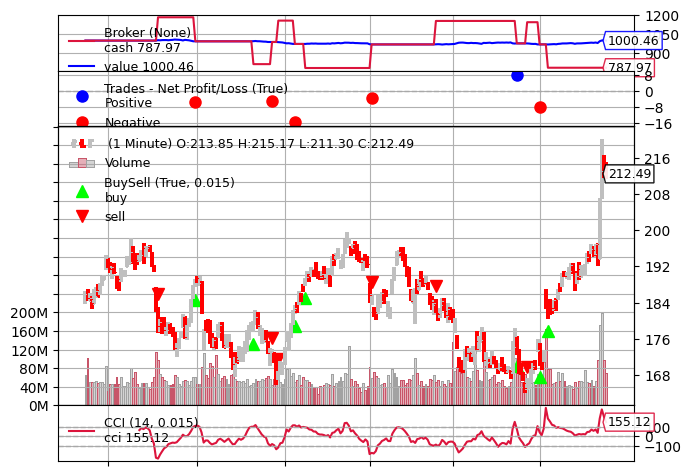

In [18]:
import matplotlib
%matplotlib inline
cerebro, thestrats = run_cerebro(strategy=BackTestStrategy, list_data=data, stake=100, cash=1000)
    #thestrat = thestrats[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print("Total point return: ", (cerebro.broker.getvalue() - cerebro.broker.startingcash))

# Plot the results
figs = cerebro.plot(
    iplot=False, 
    style="pincandle", width=60 * 10, height=40 * 10
)